# Audiobooks business case

In [69]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
import tensorflow as tf

## 1) Importing the Data

### Extract the data from the csv

In [70]:
raw_csv_data = np.loadtxt('C:\\Users\\akhan\\Desktop\\datasets\\Audiobooks_data.csv', delimiter=',')

unscaled_inputs_all = raw_csv_data[:,1:-1]
targets_all = raw_csv_data[:,-1]

In [71]:
raw_csv_data

array([[8.7300e+02, 2.1600e+03, 2.1600e+03, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [6.1100e+02, 1.4040e+03, 2.8080e+03, ..., 0.0000e+00, 1.8200e+02,
        1.0000e+00],
       [7.0500e+02, 3.2400e+02, 3.2400e+02, ..., 1.0000e+00, 3.3400e+02,
        1.0000e+00],
       ...,
       [2.8671e+04, 1.0800e+03, 1.0800e+03, ..., 0.0000e+00, 2.9000e+01,
        0.0000e+00],
       [3.1134e+04, 2.1600e+03, 2.1600e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.2832e+04, 1.6200e+03, 1.6200e+03, ..., 0.0000e+00, 9.0000e+01,
        0.0000e+00]])

### Balance the dataset

In [72]:
num_one_targets = int(np.sum(targets_all))

zero_targets_counter = 0

indices_to_remove = []

for i in range(targets_all.shape[0]):
    if targets_all[i] == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)

unscaled_inputs_equal_priors = np.delete(unscaled_inputs_all, indices_to_remove, axis=0)
targets_equal_priors = np.delete(targets_all, indices_to_remove, axis=0)

#### Note: 
as it is a classification problem, we balance the data to have equal number of each label 50%-50% (0 and 1)

### Standardize the inputs

In [73]:
scaler_deep_learning = StandardScaler()
scaled_inputs = scaler_deep_learning.fit_transform(unscaled_inputs_equal_priors)

### Shuffle the data

In [74]:
scaled_inputs.shape[0]

4474

In [75]:
shuffled_indices = np.arange(scaled_inputs.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_inputs = scaled_inputs[shuffled_indices]
shuffled_targets = targets_equal_priors[shuffled_indices]

### Split the dataset into train, validation, and test

In [76]:
samples_count = shuffled_inputs.shape[0]



split: training: 80%, validation: 10%, test: 10%

In [77]:
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)

test_samples_count = samples_count - train_samples_count - validation_samples_count

In [78]:
train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

validation_inputs = shuffled_inputs[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count+validation_samples_count]

test_inputs = shuffled_inputs[train_samples_count+validation_samples_count:]
test_targets = shuffled_targets[train_samples_count+validation_samples_count:]


In [79]:

print(np.sum(train_targets), train_samples_count, np.sum(train_targets) / train_samples_count)
print(np.sum(validation_targets), validation_samples_count, np.sum(validation_targets) / validation_samples_count)
print(np.sum(test_targets), test_samples_count, np.sum(test_targets) / test_samples_count)

1797.0 3579 0.5020955574182733
223.0 447 0.4988814317673378
217.0 448 0.484375


### Save the three datasets in *.npz

In [80]:
np.savez('Audiobooks_data_train', inputs=train_inputs, targets=train_targets)
np.savez('Audiobooks_data_validation', inputs=validation_inputs, targets=validation_targets)
np.savez('Audiobooks_data_test', inputs=test_inputs, targets=test_targets)

### Save the scaler

In [81]:
pickle.dump(scaler_deep_learning, open('scaler_deep_learning.pickle', 'wb'))

In [82]:
npz = np.load('Audiobooks_data_train.npz')

train_inputs = npz['inputs'].astype(np.float)
train_targets = npz['targets'].astype(np.int)

npz = np.load('Audiobooks_data_validation.npz')
validation_inputs, validation_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)

npz = np.load('Audiobooks_data_test.npz')
test_inputs, test_targets = npz['inputs'].astype(np.float), npz['targets'].astype(np.int)


## 2) Building The Model

In [83]:
#input_size = 10
output_size = 2
hidden_layer_size = 50

model = tf.keras.Sequential([
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                            tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
                            tf.keras.layers.Dense(output_size, activation='softmax')    
                            ])


In [84]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [85]:
batch_size = 100
max_epochs=100
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

In [86]:
model.fit(train_inputs,
          train_targets,
          batch_size=batch_size,
          epochs=max_epochs,
          callbacks=[early_stopping],
          validation_data=(validation_inputs, validation_targets),
          verbose=1
          )

Epoch 1/100
36/36 [==============================] - 0s 3ms/step - loss: 0.5779 - accuracy: 0.7670 - val_loss: 0.4531 - val_accuracy: 0.8613
Epoch 2/100
36/36 [==============================] - 0s 1ms/step - loss: 0.3829 - accuracy: 0.8748 - val_loss: 0.3339 - val_accuracy: 0.8792
Epoch 3/100
36/36 [==============================] - 0s 1ms/step - loss: 0.3131 - accuracy: 0.8874 - val_loss: 0.3031 - val_accuracy: 0.8881
Epoch 4/100
36/36 [==============================] - 0s 1ms/step - loss: 0.2918 - accuracy: 0.8908 - val_loss: 0.2865 - val_accuracy: 0.8926
Epoch 5/100
36/36 [==============================] - 0s 944us/step - loss: 0.2792 - accuracy: 0.8919 - val_loss: 0.2800 - val_accuracy: 0.8971
Epoch 6/100
36/36 [==============================] - 0s 997us/step - loss: 0.2714 - accuracy: 0.8935 - val_loss: 0.2703 - val_accuracy: 0.8971
Epoch 7/100
36/36 [==============================] - 0s 1ms/step - loss: 0.2627 - accuracy: 0.8983 - val_loss: 0.2748 - val_accuracy: 0.9016
Epoch 8/1

In [87]:
df_loss = pd.DataFrame(model.history.history)
df_loss

,loss,accuracy,val_loss,val_accuracy
0,0.577900,0.766974,0.453062,0.861298
1,0.382877,0.874825,0.333909,0.879195
2,0.313053,0.887399,0.303096,0.888143
3,0.291815,0.890752,0.286550,0.892617
4,0.279249,0.891869,0.279998,0.897092
5,0.271440,0.893546,0.270328,0.897092
6,0.262668,0.898296,0.274785,0.901566
7,0.258393,0.901928,0.274178,0.906040


<AxesSubplot:>

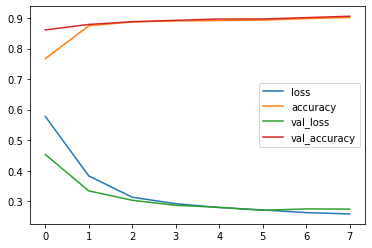

In [88]:
df_loss.plot()

## 3) Testing The Model

In [56]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

14/14 [==============================] - 0s 784us/step - loss: 0.2242 - accuracy: 0.9219


In [57]:
print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))


Test loss: 0.22. Test accuracy: 92.19%


In [58]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


#### Probability of each class:
first column is probability of being 0 or not buy and second column is probability of being 1 or buy

In [95]:
predictions_pr = model.predict(test_inputs).round(2)
predictions_pr

array([[0.15, 0.85],
       [0.86, 0.14],
       [1.  , 0.  ],
       [0.23, 0.77],
       [0.98, 0.02],
       [0.95, 0.05],
       [0.07, 0.93],
       [1.  , 0.  ],
       [0.89, 0.11],
       [0.18, 0.82],
       [0.89, 0.11],
       [0.93, 0.07],
       [0.93, 0.07],
       [0.86, 0.14],
       [0.  , 1.  ],
       [0.94, 0.06],
       [1.  , 0.  ],
       [0.96, 0.04],
       [0.96, 0.04],
       [0.91, 0.09],
       [0.85, 0.15],
       [0.  , 1.  ],
       [0.29, 0.71],
       [0.9 , 0.1 ],
       [0.95, 0.05],
       [0.26, 0.74],
       [0.81, 0.19],
       [0.22, 0.78],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.92, 0.08],
       [0.92, 0.08],
       [0.24, 0.76],
       [0.  , 1.  ],
       [0.93, 0.07],
       [0.92, 0.08],
       [0.95, 0.05],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.86, 0.14],
       [0.  , 1.  ],
       [0.35, 0.65],
       [0.93, 0.07],
       [0.17, 0.83],
       [0.13, 0.87],
       [0.39, 0.61],
       [0.26, 0.74],
       [0.54,

Alternatively we can get prediction label of each observation using these methods:

In [96]:
np.argmax(model.predict(test_inputs), axis=1)

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,

In [93]:
predictions = model.predict_classes(test_inputs)
predictions

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,

In [92]:
print('Confusion Matrix :')
print(confusion_matrix(test_targets, predictions))

Confusion Matrix :
[[207  24]
 [ 19 198]]


In [68]:
print('classification report :')
print(classification_report(test_targets, predictions))

classification report :
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       223
           1       0.92      0.93      0.92       225

    accuracy                           0.92       448
   macro avg       0.92      0.92      0.92       448
weighted avg       0.92      0.92      0.92       448

